## Wprowadzenie

W ramach tego projektu zostanie przeprowadzona analiza obejmująca wykorzystanie różnych technik uczenia maszynowego w celu zaprognozowania, czy dany pasażer linii lotniczych jest zadowolony z usług tych linii, bądź nie. 
Dane wykorzystane w pracy pochodzą z serwisu [Kaggle](https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction?select=test.csv). Baza ta zawiera odpowiedzi na pytania z ankiety przeprowadzonej na 103904 pasażerach jednej z linii lotniczych. 

Głównym celem tego projektu jest znalezienie najlepszego modelu, który będzie odpowiednio prognozował zadowolenie pasażera z usług linii lotniczych na podstawie posiadanych danych.
Jest to problem klasyfikacji binarnej, który zostanie rozwiązany za pomocą następujących modeli uczenia maszynowego: logistic regression, k-nearest neighbors algorithm, random forest oraz gradient boosting 

## 1. Przygotowanie środowiska do projektu

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 5)
import seaborn as sns
sns.set_theme()
import os
path=os.getcwd()
import json

## 2. Przygotowanie danych

Baza zawiera następujące zmienne:

- Gender: Płeć pasażera (Female, Male)
- Customer Type: Typ klienta (Loyal customer, disloyal customer)
- Age: Aktualny wiek pasażera
- Type of Travel: Cel podróży (Personal Travel, Business Travel)
- Class: Wybrana klasa w samolocie (Business, Eco, Eco Plus)
- Flight distance: Dystans jaką samolot pokonał 
- Inflight wifi service: Usługa wifi na pokładzie samolotu (0: nie dotyczy;1-5)
- Departure/Arrival time convenient: Poziom zadowolenia z dogodnego czasu odlotu/przylotu
- Ease of Online booking: Poziom satysfakcji z rezerwacji biletów online
- Gate location: Poziom satysfakcji z lokalizacji bramki do odprawy
- Food and drink: Poziom zadowolenia z żywności i napojów
- Online boarding: Poziom satysfakcji z korzystania z usług on-line dot. lotu
- Seat comfort: Poziom satysfakcji z komfortu siedzenia
- Inflight entertainment: Poziom zadowolenia z rozrywki pokładowej
- On-board service: Poziom zadowolenia z usług pokładowych
- Leg room service: Poziom zadowolenia z miejsca na nogi
- Baggage handling: Poziom satysfakcji z obsługi bagażu
- Check-in service: Poziom zadowolenia z usługi odprawy biletowo-bagażowej
- Inflight service: Poziom zadowolenia z obsługi na pokładzie samolotu
- Cleanliness: Poziom zadowolenia z czystości
- Departure Delay in Minutes: Minuty opóźnienia przy odlocie
- Arrival Delay in Minutes: Minuty opóźnienia przylotu
- Satisfaction: Poziom zadowolenia z linii lotniczych(Satisfaction, neutral or dissatisfaction)

In [2]:
#Importowanie danych
train = pd.read_csv(path+'/data/train.csv')
display(train.head())

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [3]:
#Sprawdźmy strukturę danych
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

None

In [4]:
#Sprawdzenie czy dane sie duplikują
print("Liczba zduplikowanych obserwacji w bazie treningowej:", train.duplicated().sum())


Liczba zduplikowanych obserwacji w bazie treningowej: 0


Z bazy usuwam 2 pierwsze kolumny, które nie są potrzebne do analizy. Uważam również, że zmienne opisujące poziom zadowolenia powinny być zmiennymi kategorycznymi a nie zmiennymi ciągłymi, ponieważ posiadają tylko 6 poziomów.

In [5]:
train=train.drop('Unnamed: 0', axis=1)
train=train.drop('id',axis=1)


In [6]:
#Zamiana spacji na znak podłogi w zmiennych
train.columns = [c.replace(' ', '_') for c in train.columns]
train=train.rename(columns = {'Departure/Arrival_time_convenient':'Departure_Or_Arrival_time_convenient','On-board_service':'Onboard_service'})

#Podzial zmiennych na kategoryczne cyforwe,kategoryczne slowne oraz ciagle

cat_dig_features=train.select_dtypes(include='int64').columns.values.tolist()
cat_dig_features.remove('Age')
cat_dig_features.remove('Flight_Distance')
cat_dig_features.remove('Departure_Delay_in_Minutes')
print(cat_dig_features)

cat_str_features=train.select_dtypes(include='object').columns.values.tolist()
cat_str_features.remove('satisfaction')
print(cat_str_features)

num_features=['Age','Flight_Distance','Departure_Delay_in_Minutes','Arrival_Delay_in_Minutes']
print(num_features)
#Zamiana zmiennych dot. poziomu zadowolenia na zmienne kategoryczne

train[cat_dig_features]=train[cat_dig_features].astype('object')

['Inflight_wifi_service', 'Departure_Or_Arrival_time_convenient', 'Ease_of_Online_booking', 'Gate_location', 'Food_and_drink', 'Online_boarding', 'Seat_comfort', 'Inflight_entertainment', 'Onboard_service', 'Leg_room_service', 'Baggage_handling', 'Checkin_service', 'Inflight_service', 'Cleanliness']
['Gender', 'Customer_Type', 'Type_of_Travel', 'Class']
['Age', 'Flight_Distance', 'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes']


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Gender                                103904 non-null  object 
 1   Customer_Type                         103904 non-null  object 
 2   Age                                   103904 non-null  int64  
 3   Type_of_Travel                        103904 non-null  object 
 4   Class                                 103904 non-null  object 
 5   Flight_Distance                       103904 non-null  int64  
 6   Inflight_wifi_service                 103904 non-null  object 
 7   Departure_Or_Arrival_time_convenient  103904 non-null  object 
 8   Ease_of_Online_booking                103904 non-null  object 
 9   Gate_location                         103904 non-null  object 
 10  Food_and_drink                        103904 non-null  object 
 11  

In [8]:
#Statystyki podsumowujące obie bazy
display(train.describe(include='all'))

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure_Or_Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,Onboard_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
count,103904,103904,103904.000000,103904,103904,103904.000000,103904.0,103904.0,103904.0,103904.0,...,103904.0,103904.0,103904.0,103904.0,103904.0,103904.0,103904.0,103904.000000,103594.000000,103904
unique,2,2,NaN,2,3,NaN,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,5.0,6.0,6.0,6.0,NaN,NaN,2
top,Female,Loyal Customer,NaN,Business travel,Business,NaN,3.0,4.0,3.0,3.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,neutral or dissatisfied
freq,52727,84923,NaN,71655,49665,NaN,25868.0,25546.0,24449.0,28577.0,...,29423.0,30867.0,28789.0,37383.0,29055.0,37945.0,27179.0,NaN,NaN,58879
mean,NaN,NaN,39.379706,NaN,NaN,1189.448375,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.815618,15.178678,NaN
std,NaN,NaN,15.114964,NaN,NaN,997.147281,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.230901,38.698682,NaN
min,NaN,NaN,7.000000,NaN,NaN,31.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
25%,NaN,NaN,27.000000,NaN,NaN,414.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
50%,NaN,NaN,40.000000,NaN,NaN,843.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
75%,NaN,NaN,51.000000,NaN,NaN,1743.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,13.000000,NaN


Sprawdźmy jak prezentuje się liczebność poziomów zmiennych kategorycznych

In [9]:
for col in cat_str_features+cat_dig_features:
    print(col)
    print(train[col].value_counts())
    print('--------------')

Gender
Female    52727
Male      51177
Name: Gender, dtype: int64
--------------
Customer_Type
Loyal Customer       84923
disloyal Customer    18981
Name: Customer_Type, dtype: int64
--------------
Type_of_Travel
Business travel    71655
Personal Travel    32249
Name: Type_of_Travel, dtype: int64
--------------
Class
Business    49665
Eco         46745
Eco Plus     7494
Name: Class, dtype: int64
--------------
Inflight_wifi_service
3    25868
2    25830
4    19794
1    17840
5    11469
0     3103
Name: Inflight_wifi_service, dtype: int64
--------------
Departure_Or_Arrival_time_convenient
4    25546
5    22403
3    17966
2    17191
1    15498
0     5300
Name: Departure_Or_Arrival_time_convenient, dtype: int64
--------------
Ease_of_Online_booking
3    24449
2    24021
4    19571
1    17525
5    13851
0     4487
Name: Ease_of_Online_booking, dtype: int64
--------------
Gate_location
3    28577
4    24426
2    19459
1    17562
5    13879
0        1
Name: Gate_location, dtype: int64
-----

Widać, że w części tych zmiennych poziom 0 ("nie dotyczy") jest małoliczny, co może zaburzać wyniki modelowania, dlatego warto zająć się tym w etapie inżynierii zmiennych.

### 2.1. Braki danych

Na podstawie początkowego podsumowania zbioru można zauważyć, że jedynie w przypadku zmiennej dotyczącej opóźnienie przylotu w minutach mamy doczynienia z brakami danych. Upewnijmy się.

In [10]:
print('Kolumny w train z wartościami na:\n', train.isna().sum())

Kolumny w train z wartościami na:
 Gender                                    0
Customer_Type                             0
Age                                       0
Type_of_Travel                            0
Class                                     0
Flight_Distance                           0
Inflight_wifi_service                     0
Departure_Or_Arrival_time_convenient      0
Ease_of_Online_booking                    0
Gate_location                             0
Food_and_drink                            0
Online_boarding                           0
Seat_comfort                              0
Inflight_entertainment                    0
Onboard_service                           0
Leg_room_service                          0
Baggage_handling                          0
Checkin_service                           0
Inflight_service                          0
Cleanliness                               0
Departure_Delay_in_Minutes                0
Arrival_Delay_in_Minutes                3

W przypadku tak małej ilości braków danych, zostaną one zastąpione po prostu medianą pozostałych wartości

In [11]:
train['Arrival_Delay_in_Minutes'].fillna(train['Arrival_Delay_in_Minutes'].median(),inplace=True)

print('Sprawdzenie czy braki zostały uzupełnione -> liczba braków w train:', train['Arrival_Delay_in_Minutes'].isna().sum())


Sprawdzenie czy braki zostały uzupełnione -> liczba braków w train: 0


In [12]:
#Zapisanie danych 
train.to_csv(path+'\\data\\data_prepare.csv',index=False)

with open(path+"\\data\\cat_dig_features.txt", "w") as output:
    output.write(json.dumps(cat_dig_features))
with open(path+"\\data\\cat_str_features.txt", "w") as output:
    output.write(json.dumps(cat_str_features))
with open(path+"\\data\\num_features.txt", "w") as output:
    output.write(json.dumps(num_features))

## 3. Eksploracja i analiza danych

Wstępna analiza danych pomoże prawidłowo zrozumieć posiadane zmienne, a przede wszystkim zbudować lepszy model. Zacznijmy od zmiennej zależnej.

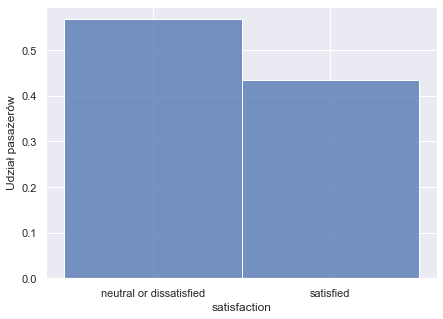

In [13]:
#Sprawdźmy najpierw czy zmienna zależna jest zbilansowana
sns.histplot(train['satisfaction'],stat='density')
plt.ylabel('Udział pasażerów')
plt.show()

Rozkład wartości tej zmienne zależnej wynosi około 57% dla poziomu neutral/dissatisfied oraz 43% dla poziomu satisfied, co oznacza, że proba jest wzglednie zbilansowana

Rozkład zmiennej zależnej w podziale na płeć

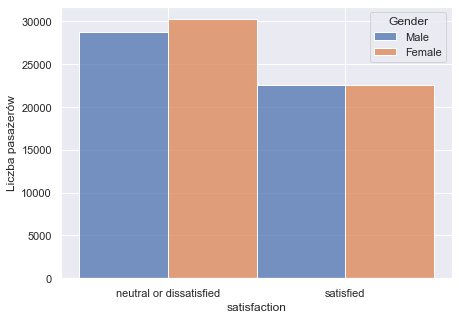

In [14]:
sns.histplot(data=train, x='satisfaction',hue='Gender',multiple='dodge')
plt.ylabel('Liczba pasażerów')
plt.show()

Podział na płeć nie różnicuje znacząco wyników, rozkład niezadowolonych i zadowolonych klientów ze względu na płeć jest praktycznie taki sam, co może być oznaką, że zmienna ta nie będzie warta uwzględniania w modelach. Warto sprawdzić w takim razie jak rozkładają się wyniki dla wieku zbadanych pasażerów

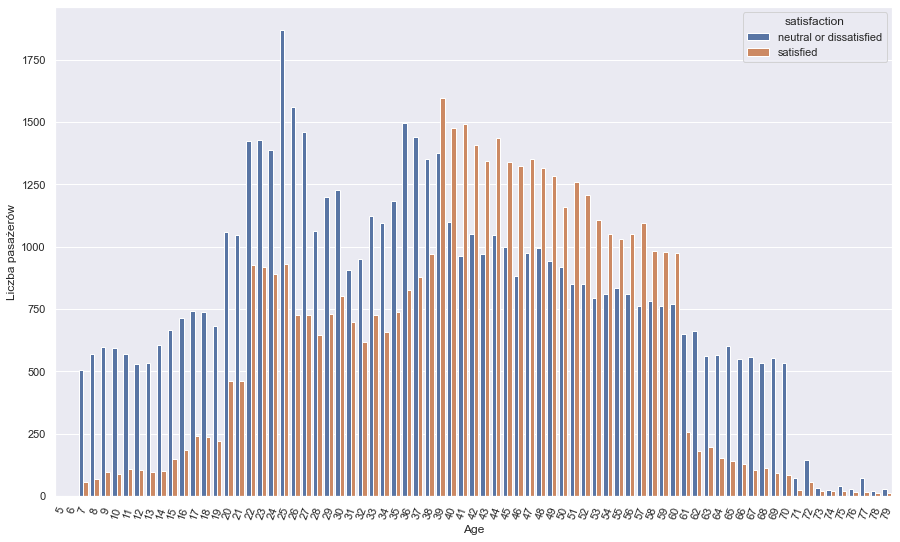

In [15]:
fig, ax = plt.subplots(figsize=(15,9))
sns.countplot(data=train,x='Age',hue='satisfaction',order=range(5, 80),ax=ax)
plt.ylabel('Liczba pasażerów')
plt.xticks(rotation=70 ) 
plt.show()

Patrząc na wykres można wyszczególnić kilka grup. Między 7 a 21 rokiem życia oraz między 61 a 79 rokiem życia liczba osób niezadowolonych jest sporo większa niż pasażerów zadowolonych. Między 22 a 38 rokiem życia udział osób zadowolonych rośnie ale dalej niedorównuje liczbie osób niezadowolonych. Dopiero między 39 a 60 rokiem życia pasażerów zadowolonych jest więcej niż tych niezadowolonych. Stanowi to ciekawą wskazówkę, aby pomyśleć o pogrupowaniu tej zmiennej w późniejszej części badania

Kolejnym oczywistym faktorem różnicującym zmienną zależną może być wybrany standard lotu, który warto dodatkowo podzielić na typ podróży

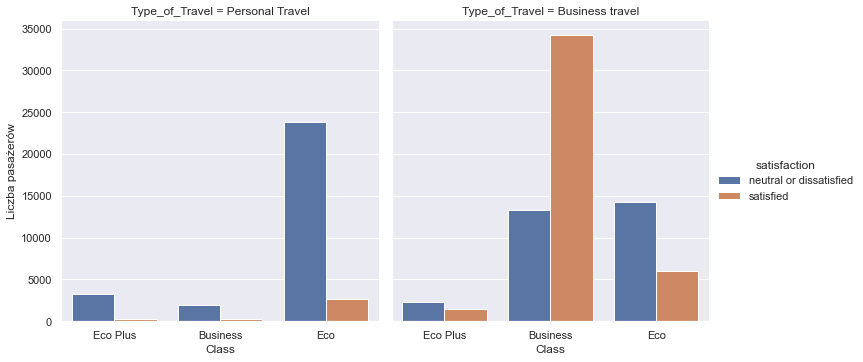

In [16]:
g=sns.catplot(data=train,x='Class',hue='satisfaction',col='Type_of_Travel',kind="count")
g.set_ylabels("Liczba pasażerów")
plt.show()

W przypadku podróży prywatnych większość osób wybiera klasę ekonomiczną i wśród nich większość osób jest niezadowolona z usług tych linii lotniczych. Natomiast w przypadku podróży zawodowych najwięcej osób wybiera klasę biznesową i około 70% z nich jest zadowolona. Co ciekawe w przypadku podróży prywatnych i wyboru klasy biznesowej nie można dostrzec tych samych prawidłowości.

Warto również zbadać jak zachowują się zmienne dotyczące długości lotu czy czasu opóźnienia przylotu/odlotu względem zmiennej objaśnianej

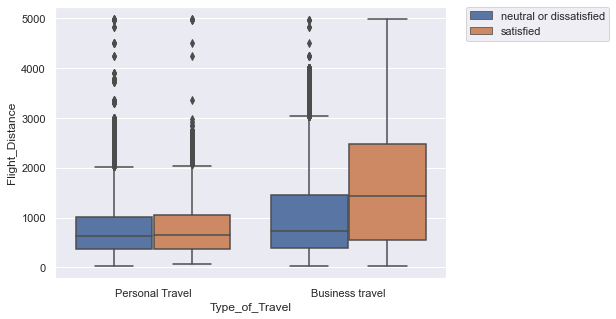

In [17]:
sns.boxplot(data=train,x='Type_of_Travel',y='Flight_Distance',hue='satisfaction')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

W przypadku lotów prywatnych nie ma różnicy w dystansie i nie przeklada się to na wyniki zmiennej zależnej. Zarówno niezadowolonych jak i zadowolonych pasażerów jest podobna ilość. Natomiast w przypadku podróży biznesowych różnica jest już widoczna. Średnio, osoby zadowolone z linii lotniczych odbywały dłuższe podróże służbowe.

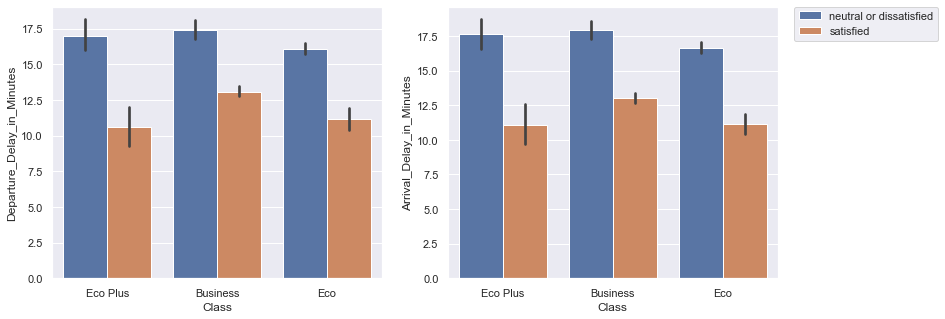

In [18]:
fig, ax = plt.subplots(1,2,figsize=(13,5))
sns.barplot(x="Class", y="Departure_Delay_in_Minutes", hue="satisfaction", data=train,ax=ax[0])
sns.barplot(x="Class", y="Arrival_Delay_in_Minutes", hue="satisfaction", data=train,ax=ax[1])
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Dla wszystkich typów standardów lotu, średnie większe opóźnienie przylotu/odlotu samolotu jest charakterystyką tych lotów, których pasażerowie nie są zadowoleni z linii lotniczych, co jest zgodne z intuicją.